### Выгрузка данных и импорт библиотек

In [59]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree
import random
from sklearn.utils import shuffle

In [5]:
X_train = pd.read_excel('data/X_train_with_scores.xlsx', sheet_name='sheet1')
X_test = pd.read_excel('data/X_test_with_scores.xlsx', sheet_name='sheet1')
X_out = pd.read_excel('data/X_out_with_scores.xlsx', sheet_name='sheet1')

y_train = pd.read_excel('data/y_train_with_scores.xlsx', sheet_name='sheet1')
y_test = pd.read_excel('data/y_test_with_scores.xlsx', sheet_name='sheet1')
y_out = pd.read_excel('data/y_out_with_scores.xlsx', sheet_name='sheet1')

In [6]:
X_train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
X_test.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
X_out.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

y_train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
y_test.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
y_out.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

y_train.columns = ['target']
y_test.columns = ['target']
y_out.columns = ['target']

In [7]:
to_drop = list()
for col in X_train.columns:
    if 'scor' in col or 'target' in col:
        to_drop.append(col)
X_train.drop(columns=to_drop, axis=1, inplace=True)
X_test.drop(columns=to_drop, axis=1, inplace=True)
X_out.drop(columns=to_drop, axis=1, inplace=True)

In [8]:
for col in X_train.columns:
    if col[0] in '1234567890':
        new_name = 'a' + col
        X_train[new_name] = X_train[col].copy()
        X_test[new_name] = X_test[col].copy()
        X_out[new_name] = X_out[col].copy()

        X_train.drop(columns=[col], axis=1, inplace=True)
        X_test.drop(columns=[col], axis=1, inplace=True)
        X_out.drop(columns=[col], axis=1, inplace=True)
        print(col)

6m_overdue2total_cnt_pdl
1y_overdue2total_cnt_pdl
1y_cnt_pdl
3m_1y_overdue_cnt_pdl


### Визуализация деревьев для просмотра веток "вживую"

In [9]:
params = {
    'max_depth': 3, 'criterion': 'gini',
    'min_samples_leaf': 200, 
    'random_state': 142, 'class_weight': {0: 1, 1: 3}
    }

In [10]:
def visualize_decision_trees(
    df: pd.DataFrame,
    vars: list[str],
    TARGET: str,
    num_forests: int = 1,
    min_samples_leaf: int = 60,
    max_depth: int = 3,
    percent_feat: float = 1.,
    pic_name: str = 'result_rules/example_tree_structure_0_v',
    show_image: bool = True,
    full_info: bool = True,
    ) -> None:
    """
    Функция для построения и визуализации нескольких деревьев решений.

    Параметры:
        Обязательные:
            - df (DataFrame): Исходный DataFrame, содержащий данные для обучения модели.
            - vars (list): Список признаков, используемых для обучения модели.
            - TARGET (str): Имя целевой переменной.
        Опциональные:
            - num_forests (int): Количество деревьев с разными случайными наборами признаков. По умолчанию 1.
            - min_samples_leaf (int): Минимальное количество объектов в одном листе дерева. По умолчанию 60.
            - max_depth (int): Максимальная глубина дерева. По умолчанию 3.
            - percent_feat (float): Процент признаков, который брать для построения нового дерева. По умолчанию 1.0.
            - pic_name (str): Путь и имя для сохранения изображения. По умолчанию 'result_rules/example_tree_structure_0_v'.
            - show_image (bool): Параметр для отображения или не отображения картинки. По умолчанию True.
            - full_info (bool): Параметр для вывода полной информации в узлах или только условие, Gini, Samples, Value. По умолчанию True.

    Визуализирует несколько деревьев решений, построенных на основе заданных параметров, и добавляет информацию к каждому узлу.

    Каждое дерево отображается на отдельной подуровне фигуры. Для каждого узла дерева выводится следующая информация:
    - Если full_info=True:
        - Условие разделения узла (по признаку и пороговому значению).
        - Количество объектов в узле.
        - Значение целевой переменной в узле.
        - Доля объектов, относящихся к данному узлу от общего числа объектов.
        - Доля объектов с отрицательным значением целевой переменной (плохие объекты) от общего числа объектов в узле.
    - Если full_info=False:
        - Условие разделения узла (по признаку и пороговому значению).
        - Значение Gini-индекса узла.
        - Количество объектов в узле.
        - Значение целевой переменной в узле.

    Если параметр show_image установлен в True (по умолчанию), изображение с деревьями будет отображено и сохранено.
    Если параметр show_image установлен в False, изображение будет сохранено по указанному пути и имени.

    Пример использования:
    visualize_decision_trees(df, vars, TARGET, num_forests=4,
                            min_samples_leaf=60, max_depth=3, percent_feat=0.7,
                            pic_name='result_rules/example_tree_structure2_v.png',
                            show_image=True, full_info=True)
    """
    from sklearn.tree import DecisionTreeClassifier
    from sklearn import tree
    from sklearn.tree import plot_tree

    # Функции для вычисления информации о сегменте и плохом отношении для узла
    def calculate_segment_info(clf_tree, node_id, df):
        sample_count = clf_tree.tree_.n_node_samples[node_id]
        class_count = clf_tree.tree_.value[node_id][0]
        segment_share = sample_count / len(df)
        bad_rate = class_count[1] / (class_count[0] + class_count[1])
        return segment_share, bad_rate

    # Функция для получения условия разделения узла
    def get_node_condition(clf_tree, node_id, vars):
        feature = clf_tree.tree_.feature[node_id]
        threshold = clf_tree.tree_.threshold[node_id]
        if feature != -2:
            feature_name = vars[feature]
            condition = f"{feature_name} <= {threshold:.3f}"
        else:
            condition = "Leaf"
        return condition

    # Функция для добавления информации к узлу
    def add_node_info(text, segment_share, bad_rate, condition, gini, samples, value, full_info):
        if full_info:
            info_text = f"{condition}\nSamples: {samples}\nValue: {list(map(int, value))}\nSegment Share: {segment_share:.2%}\nBad Rate: {bad_rate:.2%}"
        else:
            info_text = f"{condition}\nGini: {gini:.3f}\nSamples: {samples}\nValue: {list(map(int, value))}"
        text.set_text(info_text)

    # Создание и обучение классификатора деревьев решений
    clf_trees = []
    for i in range(num_forests):
        clf_tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=int(percent_feat * len(vars)),
            random_state=i + 142
        )
        clf_tree.fit(df[vars], df[TARGET])
        clf_trees.append(clf_tree)

        # Сохранение каждого дерева на отдельной картинке
        fig, ax = plt.subplots(figsize=(40, 25))
        plot_tree(
            clf_tree,
            feature_names=vars,
            ax=ax,
            impurity=True,
            rounded=True
        )

        # Добавление информации к каждому узлу (включая корневой узел)
        nodes = ax.get_children()[1:]  # Исключение корневого узла
        for j, text in enumerate(ax.texts):
            segment_share, bad_rate = calculate_segment_info(clf_tree, j, df)
            condition = get_node_condition(clf_tree, j, vars)
            gini = clf_tree.tree_.impurity[j]
            samples = clf_tree.tree_.n_node_samples[j]
            value = clf_tree.tree_.value[j][0]
            add_node_info(text, segment_share, bad_rate, condition, gini, samples, value, full_info)

        plt.savefig(f"{pic_name}{i}.png")
        if show_image:
            plt.show()
        plt.close()

### Обход деревьев без объединения веток в одном дереве

In [11]:
def tree_to_code(tree, feature_names, df, BR):

    """Функция рекурсивно проходится по заданному дереву, и в случае обнаружения ветки
    с пониженным BR, записывает её путь и показатели(BR, segment_share) в итоговый список"""

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature]
    
    result = list()

    def recurse(node, depth, s):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = round(tree_.threshold[node], 3)

            sample_count = tree_.n_node_samples[node]
            class_count = tree_.value[node][0]
            segment_share = round(sample_count / len(df), 3)
            bad_rate = round(class_count[1] / (class_count[0] + class_count[1]), 3)

            if bad_rate < BR:
                result.append((s[1:], round(bad_rate, 3), round(segment_share, 3)))
                #print ("rule: {}, curr_BR = {}, curr_SS {}:)".format(s[1:], bad_rate, segment_share))
            s1 = "({} <= {})".format(name, threshold)
            recurse(tree_.children_left[node], depth + 1, s + '&' + s1)
            s2 = "({} > {})".format(name, threshold)
            recurse(tree_.children_right[node], depth + 1, s + '&' + s2)
        else:
            sample_count = tree_.n_node_samples[node]
            class_count = tree_.value[node][0]
            segment_share = round(sample_count / len(df), 3)
            bad_rate = round(class_count[1] / (class_count[0] + class_count[1]), 3)
            if bad_rate < BR:
                result.append((s[1:], round(bad_rate, 3), round(segment_share, 3)))
                #print ("rule: {}, curr_BR = {}, curr_SS = {}:)".format(s[1:], bad_rate, segment_share))

    recurse(0, 1, '')
    return result

In [49]:
def rules_search(X_train, y_train, vars, BR_dwn=30):

    """Строит множество деревьев решений на рандомно извлечённых признаках из vars,
    затем проходится по построенным деревьям, и в случае обнарежения ветки с достаточно
    пониженным BR (больше указанного BR_dwn - в процентах), записывает данную ветку в итог.
    
    Функция возвращает датафрэйм с указанным рулом, BR-ом после его применения и долей остатка выборки"""

    from sklearn.utils import shuffle
    result_rules = list()
    columns = vars

    BR_curr = y_train.mean().values[0]
    BR_need = BR_curr * (1 - BR_dwn/100)

    for k in range(20):
        columns = shuffle(columns, random_state=k)
        for i in range(0, len(columns), 7):
            curr = columns[i:i+7]
            clf_tree = DecisionTreeClassifier(
                max_depth=3,
                min_samples_leaf=100
            )
            clf_tree.fit(X_train[curr], y_train.target)
            vals = tree_to_code(clf_tree, curr, X_train, BR_need)
    
            result_rules += vals
            
    return pd.DataFrame(data=result_rules, columns=['rule', 'BR', 'Segm_share']).sort_values('Segm_share', ascending=False)   

### Обход деревьев с объединением веток в одном дереве

In [4]:
def tree_to_code_up_down(tree, feature_names, df, y, BR):

    """Функция рекурсивно проходится по заданному дереву, и в случае обнаружения ветки
    с пониженным BR, записывает её путь и показатели(BR, segment_share) в список. Теперь в списке лежат все ветки одного дерева с пониженным BR,
    далее, я с помощью itertools.combinations(здесь можно юзать, так как в одном дереве максимум ветки 3 с пониженным BR), перебираю
    все возможные вариации объединения этих веток в единое правило. Так-же все объединения проверяю на BR, и вывожу значение с самым больших Segm_share"""

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature]
    
    result = list()

    def recurse(node, depth, s):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = round(tree_.threshold[node], 3)

            sample_count = tree_.n_node_samples[node]
            class_count = tree_.value[node][0]
            segment_share = round(sample_count / len(df), 3)
            bad_rate = round(class_count[1] / (class_count[0] + class_count[1]), 3)

            if bad_rate < BR:
                result.append((s[1:], round(bad_rate, 3), round(segment_share, 3)))
                #print ("rule: {}, curr_BR = {}, curr_SS {}:)".format(s[1:], bad_rate, segment_share))
                return

            s1 = "({} <= {})".format(name, threshold)
            recurse(tree_.children_left[node], depth + 1, s + '&' + s1)
            s2 = "({} > {})".format(name, threshold)
            recurse(tree_.children_right[node], depth + 1, s + '&' + s2)
        else:
            sample_count = tree_.n_node_samples[node]
            class_count = tree_.value[node][0]
            segment_share = round(sample_count / len(df), 3)
            bad_rate = round(class_count[1] / (class_count[0] + class_count[1]), 3)
            if bad_rate < BR:
                result.append((s[1:], round(bad_rate, 3), round(segment_share, 3)))
                #print ("rule: {}, curr_BR = {}, curr_SS = {}:)".format(s[1:], bad_rate, segment_share))
            return

    recurse(0, 1, '')

    if len(result) <= 1:
        return result[0]
        
    # result = sorted(result, key=lambda x: x[2], reverse=True)#Сортирую список по убыванию по segm_share

    def search_comb(df, y, result):

        import itertools
        df['target'] = y.target

        fin = list()
        all_comb = []
        for i in range(1, len(result)+1):
            cr = itertools.combinations(range(len(result)), i)
            all_comb += cr

        for comb in all_comb:
            curr_filt = ''
            for ind in comb:
                curr_filt += '|' + '(' + result[ind][0] + ')'
            curr_filt = curr_filt[1:]
            curr_BR = df.query(curr_filt).target.mean() #значение BR
            curr_prt = (df.query(curr_filt).shape[0] / df.shape[0]) #часть оставшейся выборки
            if curr_BR < BR:
                fin.append((curr_filt, round(curr_BR, 3), round(curr_prt, 3)))
                
        df.drop(columns=['target'], axis=1, inplace=True)

        return fin 
        
    fin = search_comb(df, y, result)
    fin = sorted(fin, key=lambda x: x[2], reverse=True) #Сортирую список по убыванию по segm_share и вывожу в результат лучшую комбинацию веток
    return fin[0]

In [2]:
def rules_search_up_down(X_train, y_train, vars, BR_dwn=30):

    """Строит множество деревьев решений на рандомно извлечённых признаках из vars,
    затем проходится по построенным деревьям, и в случае обнарежения ветки с достаточно
    пониженным BR (больше указанного BR_dwn - в процентах), записывает данную ветку в итог.
    Если в одном дереве присутстует несколько веток с пониженным BR, 
    то функция их объединяет (по условиям BR_dwn - т.е. получаются 'деревья') и записывает в итог.
    
    Функция возвращает датафрэйм с указанным рулом, BR-ом после его применения и долей остатка выборки"""
    from sklearn.utils import shuffle
    result_rules = list()
    columns = vars

    BR_curr = y_train.mean().values[0]
    BR_need = BR_curr * (1 - BR_dwn/100)

    for k in range(20):
        columns = shuffle(columns, random_state=k)
        for i in range(0, len(columns), 7):
            curr = columns[i:i+7]
            clf_tree = DecisionTreeClassifier(
                max_depth=3,
                min_samples_leaf=100
            )
            clf_tree.fit(X_train[curr], y_train.target)
            vals = tree_to_code_up_down(clf_tree, curr, X_train, y_train, BR_need)
    
            result_rules.append(vals)
            
    return pd.DataFrame(data=result_rules, columns=['rule', 'BR', 'Segm_share']).sort_values('Segm_share', ascending=False)      

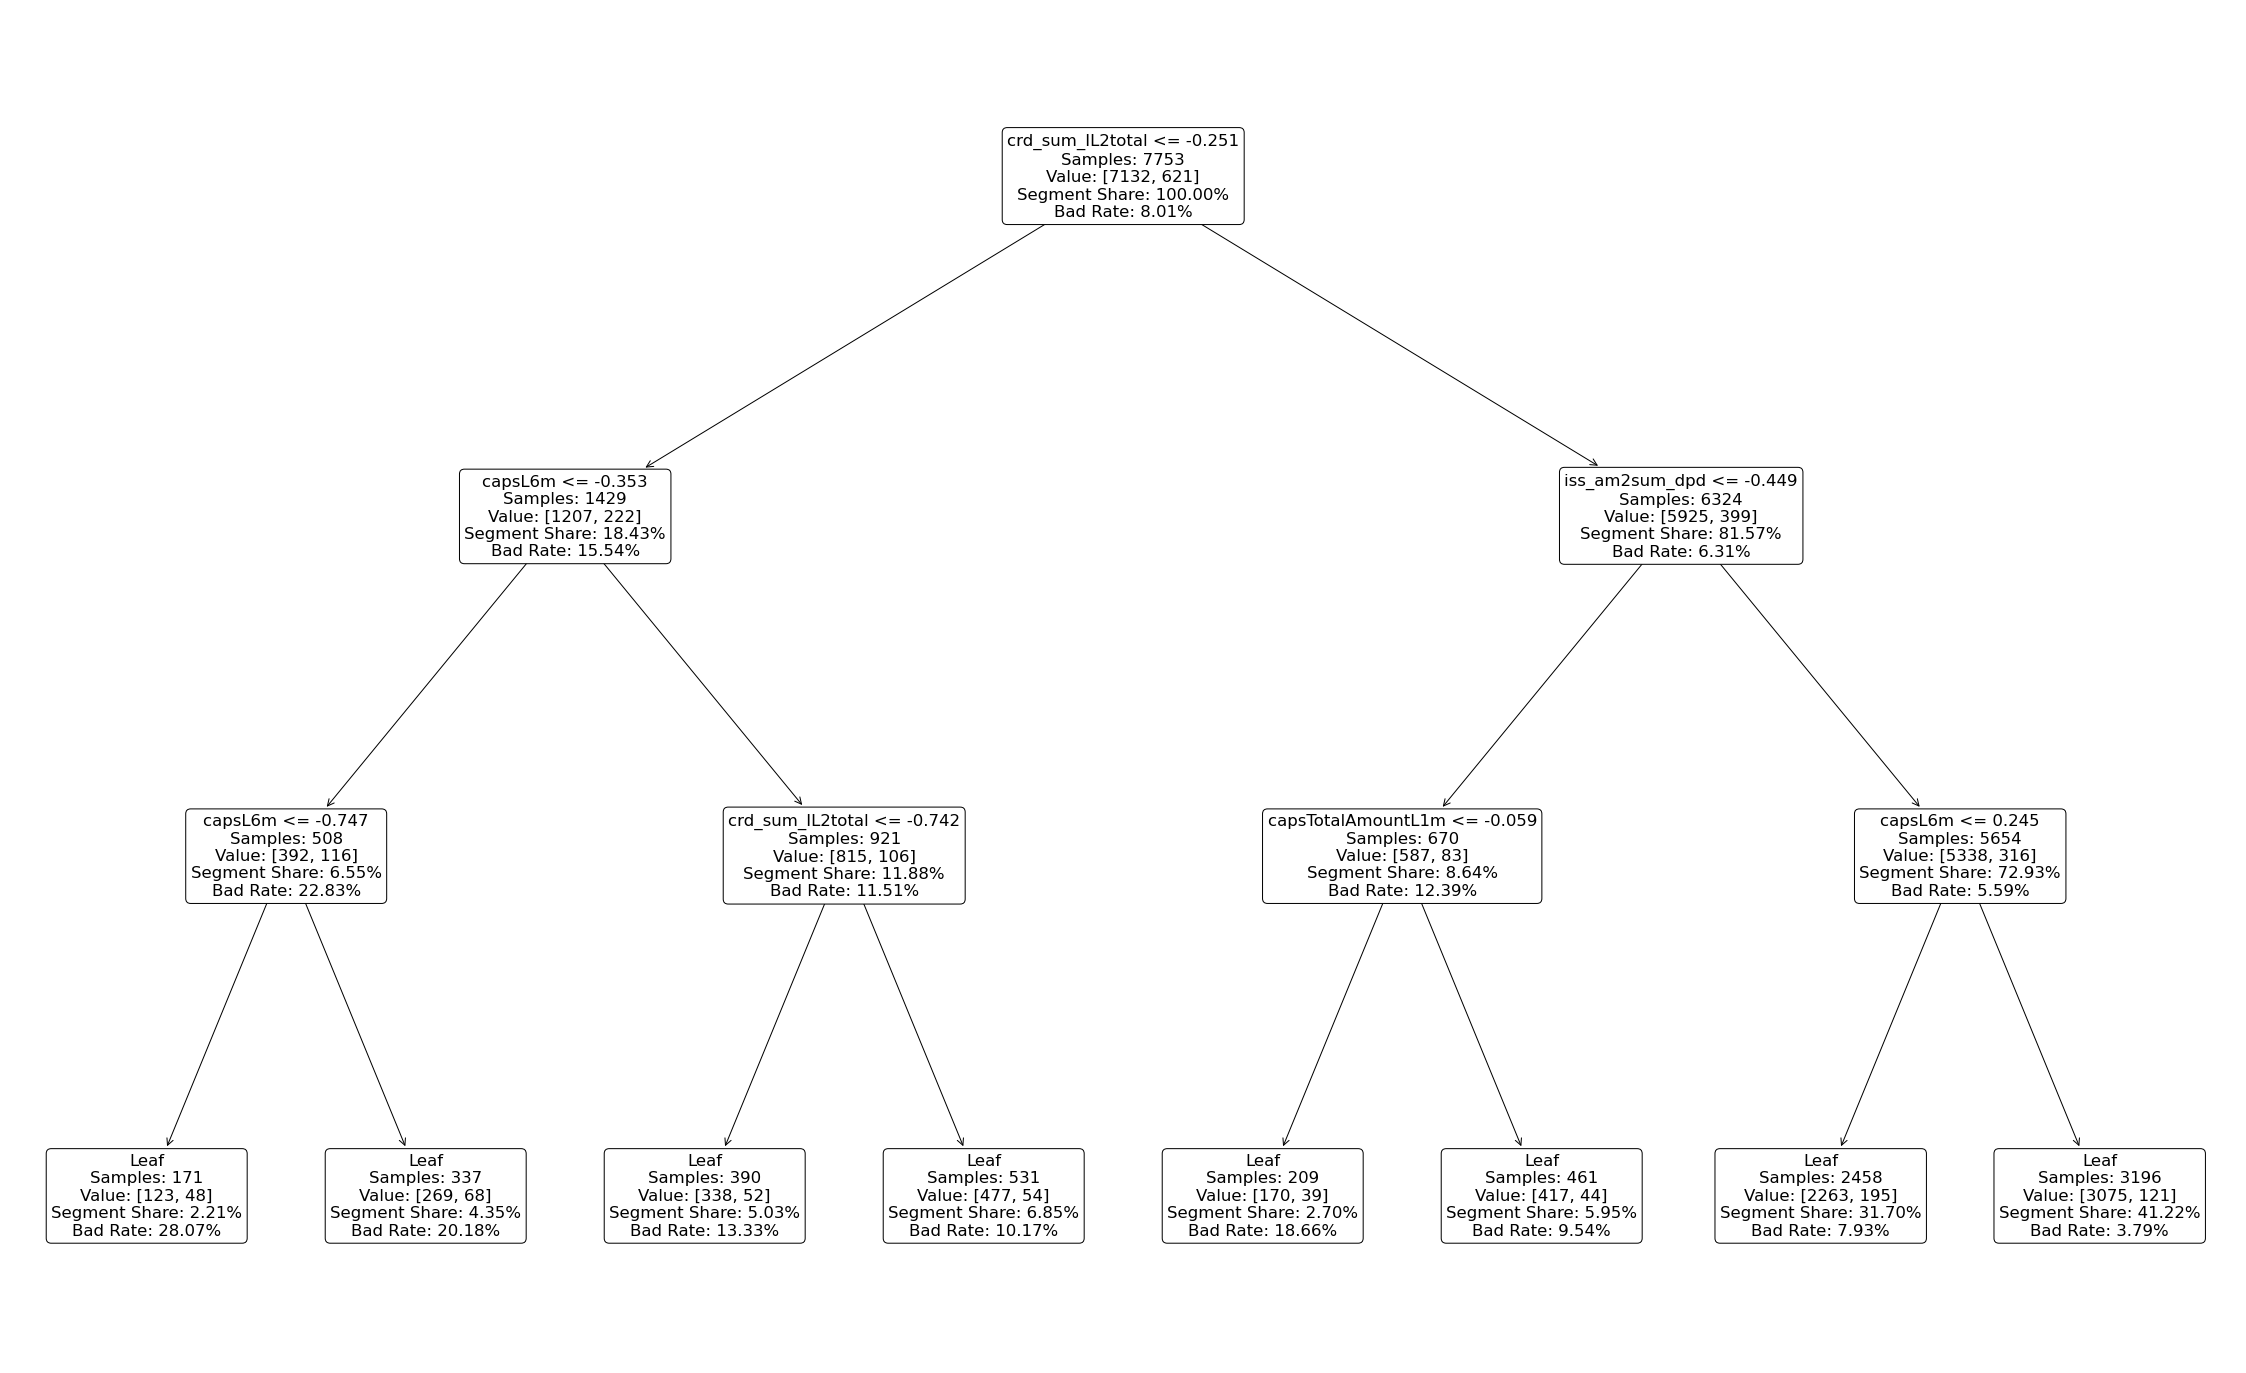

In [14]:
vars_woe = ['capsL6m', 'iss_am2sum_dpd', 'crd_sum_IL2total', 'capsTotalAmountL1m']
X = pd.concat([X_train, X_test, X_out])
d = pd.concat([y_train, y_test, y_out])
X['target'] = d.target
visualize_decision_trees(X, vars_woe, 'target', num_forests=1,
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth=params['max_depth'], 
                        percent_feat=1,
                        pic_name='result_rules/example_tree_structure2_v3.png', 
                        show_image=True, full_info=True)

### Ручной подбор фильтров 
(использовать при необходимости ручного подбора фильтров, функции не используются в основом расчёте)

In [177]:
def calculate_res_BR(X, y):

    """Функция принимает: 
                X - датафрэйм с необходимыми для фильтрации признаками
                y - соответствующий датафрэйм, со значением таргета(необходим для расчёта значений)

        Данная функция подходит для прописывания фильтров и анализа их способностей.
    Подбирая различные комбинации признаков (vars_woe), на них можно строить деревья-решений, 
    смотреть на ветки с пониженныйм BR, и если он понизился на необходимую долю,
    записать данную ветку как отдельный фильтр.
    В дальнейшем, самостоятельно собирать фильтры в один (т.к. для расчёта фильтров используется функция "query",
    принимающая в качестве агрумента строку, то объединять следует через конкатенацию
    строк фильтров с "|" - логические "или", обособляя фильтры скобками) и первично оценивать взаимодействие полученный фильтров"""

    X['target'] = y.target

    # Пример прописывания рулов(фильтров)

    f0 = '(target >= 0)'
    f1 = '(capsL6m > 0.353)&(iss_am2sum_dpd > -0.449)&(crd_sum_IL2total > -0.449)'
    f2 = '(capsL6m > 0.245)&(crd_sum_IL2total > -0.251)'
    f3 = '(capsL3m > -0.075)&(iss_am2sum_dpd > -0.449)&(crd_sum_IL2total > -0.251)'
    
    # Пример объединения в единый фильтр

    full_filtr = '(' + f1 + ')' + '|' + '(' + f2 + ')' + '|' + '(' + f3 + ')'

    BR_dwn = round((1 - X.query(full_filtr).target.mean()/X.target.mean())*100, 3)
    prt = round((X.query(full_filtr).shape[0] / X.shape[0]) * 100, 3)
    BR_curr = round(X.query(full_filtr).target.mean()*100, 3)
    
    #Функция ворзвращает BR_dwn - на сколько процентов понизился BR от начального, после применения указанных фильтров
    #                    prt - процент оставшейся выборки с пониженный BR (то, что осталость после среза фильтром)
    #                    BR_curr - текущий BR на получившейся выборке

    return BR_dwn, prt, BR_curr

In [178]:
def BR_data_samples(X_train, X_test, X_out, y_train, y_test, y_out):

    """Функция принимает:
                X_train, X_test, X_out - датафрэймы с необходимыми для фильтрации признаками
                y_train, y_test, y_out - соответствующие df, со значением таргета(необходим для расчёта значений)
        
       Функция объединяет аналитику по объединённому фильтру в calculate_res_BR, для выборок train, test, out"""

    BR_dwn_train, prt_train, BR_curr_train = calculate_res_BR(X_train, y_train)
    BR_dwn_test, prt_test, BR_curr_test = calculate_res_BR(X_test, y_test)
    BR_dwn_out, prt_out, BR_curr_out = calculate_res_BR(X_out, y_out)

    df = pd.DataFrame(index=['train', 'test', 'out'], 
                      columns = ['BR_dwn', 'prt', 'BR_curr'], 
                      data = [[BR_dwn_train, prt_train, BR_curr_train], 
                              [BR_dwn_test, prt_test, BR_curr_test], 
                              [BR_dwn_out, prt_out, BR_curr_out]])
    
    #Ворзвращает датафрэйм со значениями BR_dwn, prt, BR_curr для всех выборок
    
    return df

### Основные функции

In [184]:
# def filter_df(nums):

#     #СТАРАЯ ФУНКЦИЯ, ПРИНИМАЕТ ТОЛЬКО ИНДЕКСЫ, ФИЛЬТРЫ НЕОБХОДИМО ПРОПИСЫВАТЬ ВРУЧНУЮ!
    
#     """Функция принимает:
#                 nums - индексы фильтров (номер фильтра минус 1)
                         
#        Предназначена для объединения фильтров для текущего датарфэма
#        по определённым индексам(используется в последующих расчётных функциях)"""
    
#     #Фильтры, применяемые в данной функции, копировать(просто строками) из отобранных фильтров в функции 'calculate_res_BR'

#     # Пример прописывания веток с пониженный BR

#     f1 = '(feat1 > 0.353)&(feat2 > -0.449)&(feat3 > -0.449)'
#     f2 = '(feat4 > 0.353)&(feat5 > -0.449)&(feat6 > -0.449)'



#     #Необходимо прописать полученные фильтры в виде списка
#     # (лучше нумеровать фильтры - 1, 2, 3..., чтобы в дальнейшем не было путаницы с номерами)

#     #Пример

#     filters = [f1, f2]

#     res_filt = '(' + filters[nums[0]] + ')'
#     if len(nums) == 1:
#         return res_filt
#     for i in range(1, len(nums)):
#         res_filt += '|' + '(' + filters[nums[i]] + ')'

#     #Возвращает:
#     #       res_filt - объединённые фильтры в виде строки
#     return res_filt

In [143]:
def filter_df(nums, filters_list):
    
    """Функция принимает:
                nums - индексы фильтров (номер фильтра минус 1)
                filters_list - общий список фильтров, идущий на фильтрацию

       Предназначена для объединения фильтров для датарфэма
       по определённым индексам.
       (используется в последующих расчётных функциях)"""
    

    filters = filters_list.copy()

    res_filt = '(' + filters[nums[0]] + ')'
    if len(nums) == 1:
        return res_filt
    for i in range(1, len(nums)):
        res_filt += '|' + '(' + filters[nums[i]] + ')'

    #Возвращает:
    #       res_filt - объединённые фильтры в виде строки
    return res_filt


def calculate_values(df, filters):

    """Фукнция принимает: 
                df - фильтруемый датафрэйм (уже с колонкой таргета)
                filters - строка с комбинацией фильтров"""

    BR_dwn = round((1 - df.query(filters, engine='python').target.mean()/df.target.mean())*100, 3) #снижение BR в %
    prt = round((df.query(filters, engine='python').shape[0] / df.shape[0])*100, 3) #часть оставшейся выборки
    BR_curr = round(df.query(filters, engine='python').target.mean()*100, 3) #значение BR
    #Возваращает значения BR_dwn, prt, BR_curr для отфильтрованного датафрэйма 
    return BR_dwn, prt, BR_curr

In [122]:
def random_step_by_step_learn(X_train, y_train, filters_list, trsh_hld=30):

    """Функция принимает:
            X_train - обучающий датафрэйм с необходимыми для фильтрации признаками
            y_train - соответствующий начальные df, со значением таргета(необходим для расчёта значений)
            filters_list - список используемых фильтров
            trsh_hld - минимально допустимый процент понижения BR на отфильтрованной выборке
                    (если необходимо понизить BR на 30 процентов, то выставлять trsh_hld=30)
                
            Данная функция для каждого фильтра, несколько раз добавляет рандомную последовательность фильтров.
        На каждом шаге добавления нового фильтра из рандомной последовательности, проводится проверка по trsh_hld,
        если результат удовлетворяет требованиям, то текущая комбинация добавляется в итоговый датарэйм,
        а фильтр добавляется в результирующий и процесс подбора продолжается.
        
            Таким образом, получается, что для каждого фильтра в итоговом датафрэйме, будет присутствовать
        несколько комбинаций с другими фильтрами, различной длины"""

    from sklearn.utils import shuffle

    X_train['target'] = y_train.target

    filter_ind = list(range(len(filters_list)))

    combinations = pd.DataFrame(columns=['filt_ind', 'BR_dwn_train', 'prt_train', 'BR_curr_train'])

    p = 1
    i = 0
    for ind in range(len(filters_list)):

        for _ in range(len(filters_list)):
            res = list()
            res.append(ind)

            train_filt = filter_df([ind], filters_list)

            BR_dwn_train, prt_train, BR_curr_train = calculate_values(X_train, train_filt)
            curr_max_prt = prt_train

            filter_ind = shuffle(filter_ind, random_state=p)
            p += 1
            for j in filter_ind:
                if j in res:
                    continue
                else:

                    check = res + [j]
                    train_filt = filter_df(check, filters_list)

                    BR_dwn_train, prt_train, BR_curr_train = calculate_values(X_train, train_filt)

                    if BR_dwn_train > trsh_hld and prt_train >= 1.02 * curr_max_prt:
                        res.append(j)
                        curr_max_prt = prt_train
                        combinations.loc[i, 'filt_ind'] = res.copy()
                        combinations.loc[i, 'BR_dwn_train'] = BR_dwn_train
                        combinations.loc[i, 'prt_train'] = prt_train
                        combinations.loc[i, 'BR_curr_train'] = BR_curr_train
                        i += 1

    combinations['filt_ind'] = combinations['filt_ind'].apply(sorted).apply(str)
    X_train.drop(columns=['target'], axis=1, inplace=True)
    #Возвращает датафрэйм со столбцом, с номерами используемых фильтров, 
    # и значениями показателей на всех выборках
    return combinations.drop_duplicates()

In [17]:
def Greed_search_learn(X_train, y_train, filters_list, trsh_hld=30, max_res_cnt_filters=5):

    """Функция принимает:
            X_train - обучающий датафрэйм с необходимыми для фильтрации признаками
            y_train - соответствующий начальные df, со значением таргета(необходим для расчёта значений)
            filters_list - список используемых фильтров
            trsh_hld - минимально допустимый процент понижения BR на отфильтрованной выборке
                    (если необходимо понизить BR на 30 процентов, то выставлять trsh_hld=30)
            max_res_cnt_filters - максимальное количество фильтров, которое можно добавить в процессе жадного алгоритма
                
            Данная функция для каждого фильтра, проходится по всему списку фильтров жадным поиском, и добавляет тот фильтр,
        с которым текущая комбинация фильтров даёт наилучший результат, при чём, каждый фильтр проверяется по требованиям trsh_hld,
        и специальному условию, что на каждом шаге, объём результирующей выборки должен расти. Если условия не выполняются,
        то для текущего фильтра поиск прекращается, результаты заносятся в итоговую таблицу, и начинается поиск для следующего фильтра.
        
        В результате, получается несколько (не больше количества фильтров) комбинаций, представленных в датафрэйме"""

    def rnd(x):
        return round(x)

    X_train['target'] = y_train.target

    filter_ind = list(range(len(filters_list)))

    combinations = pd.DataFrame(columns=['filt_ind', 'BR_dwn_train', 'prt_train', 'BR_curr_train'])

    i = 0
    for ind in filter_ind:
        res = list()
        res.append(ind)

        train_filt = filter_df(res, filters_list)

        BR_dwn_train, prt_train, _ = calculate_values(X_train, train_filt)

        curr_prt_max = round(prt_train)

        if BR_dwn_train >= trsh_hld:

            cnt = max_res_cnt_filters - 1
            while cnt != 0:
                curr = pd.DataFrame(columns=['filt_ind', 'BR_dwn_train', 'prt_train'])

                j = 0
                for filt in filter_ind:

                    if filt not in res:
                        check = res + [filt]
                        train_filt = filter_df(check, filters_list)

                        BR_dwn_train, prt_train, _ = calculate_values(X_train, train_filt)
                        
                        if BR_dwn_train > trsh_hld:
                            curr.loc[j, 'filt_ind'] = [filt]
                            curr.loc[j, 'BR_dwn_train'] = BR_dwn_train
                            curr.loc[j, 'prt_train'] = prt_train
                            j += 1

                if j != 0:

                    curr['BR_dwn_train'] = curr['BR_dwn_train'].apply(rnd)
                    curr['prt_train'] = curr['prt_train'].apply(rnd)

                    curr = curr.sort_values(['prt_train', 'BR_dwn_train'], ascending=[False, False])
                    
                    if curr['BR_dwn_train'].values[0] >= trsh_hld and curr['prt_train'].values[0] >= curr_prt_max:
                        res.append(curr['filt_ind'].values[0][0])
                        curr_prt_max = curr['prt_train'].values[0]
                    else:
                        break

                cnt -= 1
            
            train_filt = filter_df(res, filters_list)

            BR_dwn_train, prt_train, BR_curr_train = calculate_values(X_train, train_filt)
                        
            combinations.loc[i, 'filt_ind'] = res.copy()
            combinations.loc[i, 'BR_dwn_train'] = BR_dwn_train
            combinations.loc[i, 'prt_train'] = prt_train
            combinations.loc[i, 'BR_curr_train'] = BR_curr_train
            i += 1
    combinations['filt_ind'] = combinations['filt_ind'].apply(sorted).apply(str)

    X_train.drop(columns=['target'], axis=1, inplace=True)   
    #Возвращает датафрэйм со столбцом, с номерами используемых фильтров, 
    # и значениями показателей на всех выборках
    return combinations.drop_duplicates()

In [100]:
def all_sample_data(X_train, X_test, X_out, 
                    y_train, y_test, y_out, 
                    filters_list, combinations):

    """Функция принимает:
            X_train, X_test, X_out - датафрэймы с необходимыми для фильтрации признаками
            y_train, y_test, y_out - соответствующий df, со значением таргета(необходим для расчёта значений)
            filters_list - список используемых фильтров
            combinations - датафрэйм, являющийся результатом работы функций "Greed_search_learn" или "Random_step_by_step_learn"

                
            Данная функция по значениям комбинация в колонке 'filt_ind' датафрэйма combinations,
        рассчитывает значения 'BR_dwn', 'prt', 'BR_curr', для train, test и out выборок.
            
            В результате получается датафрэйм, с результатами для всех выборок по фильтрам,
        которые были получены, в процессе 'обучения' на train"""

    #В filtr_ind - хранятся строки со списками, поэтому перевожуперевожу их обратно в списки
    to_check = list(combinations['filt_ind'].values)
    to_check = list(map(lambda x: x[1:-1].split(', '), to_check))

    #Для получения индексов, перевожу строковые числа в int

    
    result =  pd.DataFrame(columns=['filters', 'filt_cnt', 'BR_dwn_train', 'prt_train', 'BR_curr_train',
                                        'BR_dwn_test', 'prt_test', 'BR_curr_test', 
                                        'BR_dwn_out', 'prt_out', 'BR_curr_out'])

    
    X_train['target'] = y_train.target
    X_test['target'] = y_test.target
    X_out['target'] = y_out.target
    
    i = 0
    for val in to_check:
        inxs = list(map(lambda x: int(x), val))

        filt = filter_df(inxs, filters_list)

        BR_dwn_train, prt_train, BR_curr_train = calculate_values(X_train, filt)
        BR_dwn_test, prt_test, BR_curr_test = calculate_values(X_test, filt)
        BR_dwn_out, prt_out, BR_curr_out = calculate_values(X_out, filt)
                    
        result.loc[i, 'filters'] = filt
        result.loc[i, 'filt_cnt'] = len(inxs)
        result.loc[i, 'BR_dwn_train'] = BR_dwn_train
        result.loc[i, 'prt_train'] = prt_train
        result.loc[i, 'BR_curr_train'] = BR_curr_train
        result.loc[i, 'BR_dwn_test'] = BR_dwn_test
        result.loc[i, 'prt_test'] = prt_test
        result.loc[i, 'BR_curr_test'] = BR_curr_test
        result.loc[i, 'BR_dwn_out'] = BR_dwn_out
        result.loc[i, 'prt_out'] = prt_out
        result.loc[i, 'BR_curr_out'] = BR_curr_out
        i += 1

    X_train.drop(columns=['target'], axis=1, inplace=True)
    X_test.drop(columns=['target'], axis=1, inplace=True)
    X_out.drop(columns=['target'], axis=1, inplace=True)

    return result

In [19]:
def all_sample_data_with_learning(X_train, X_test, X_out, 
                                  y_train, y_test, y_out, 
                                  filters_list, trsh_hld=30, 
                                  type_search='greed', max_res_cnt_filters=None):

    """Функция принимает:
            X_train, X_test, X_out - датафрэймы с необходимыми для фильтрации признаками
            y_train, y_test, y_out - соответствующий df, со значением таргета(необходим для расчёта значений)
            filtr_cnt - датафрэйм, являющийся результатом работы функций "Greed_search_learn" или "Random_step_by_step_learn"
            trsh_hld - минимально допустимый процент понижения BR на отфильтрованной выборке

            type - тип поиска комбинаций ('random' - random_step_by_step_learn
                                          'greed' - Greed_search_learn, или different_cnt_greed_learn)

            max_res_cnt_filters - (указывать в слуае type='greed')
                                    - Если передать число - type == int, то функция рассчитает по Greed_search_learn, 
                                то есть для определённого максимального значения фильтров
                                    - Если передать список - type == list, то функция рассчитает по different_cnt_greed_learn,
                                то есть для различных значений макс. кол-ва фильтров.

            Данная функция сначала 'обучается' на указанной X_train, y_train - выборках, а потом,
        рассчитывает значения 'BR_dwn', 'prt', 'BR_curr', для train, test и out выборок.
            
            В результате получается датафрэйм, с результатами для всех выборок по фильтрам,
        которые были получены, в процессе 'обучения' на train"""

    if type_search == 'greed':
        combinations = Greed_search_learn(X_train, y_train, filters_list, trsh_hld=trsh_hld, max_res_cnt_filters=max_res_cnt_filters)

    elif type_search == 'random':
        combinations = random_step_by_step_learn(X_train, y_train, filters_list, trsh_hld=trsh_hld)
        
    else:
        combinations = Greed_search_learn(X_train, y_train, filters_list, trsh_hld=trsh_hld, max_res_cnt_filters=max_res_cnt_filters)

    #В filtr_num - хранятся строки со списками, поэтому перевожуперевожу их обратно в списки
    to_check = list(combinations['filtr_num'].values)
    to_check = list(map(lambda x: x[1:-1].split(', '), to_check))

    #Для получения индексов, перевожу строковые числа в int

    
    result =  pd.DataFrame(columns=['filt_num', 'BR_dwn_train', 'prt_train', 'BR_curr_train',
                                        'BR_dwn_test', 'prt_test', 'BR_curr_test', 
                                        'BR_dwn_out', 'prt_out', 'BR_curr_out'])

    
    X_train['target'] = y_train
    X_test['target'] = y_test
    X_out['target'] = y_out
    
    i = 0
    for val in to_check:
        inxs = list(map(lambda x: int(x), val))

        filt = filter_df(inxs, filters_list)

        BR_dwn_train, prt_train, BR_curr_train = calculate_values(X_train, filt)
        BR_dwn_test, prt_test, BR_curr_test = calculate_values(X_test, filt)
        BR_dwn_out, prt_out, BR_curr_out = calculate_values(X_out, filt)
                    
        result.loc[i, 'filt_num'] = inxs.copy()
        result.loc[i, 'BR_dwn_train'] = BR_dwn_train
        result.loc[i, 'prt_train'] = prt_train
        result.loc[i, 'BR_curr_train'] = BR_curr_train
        result.loc[i, 'BR_dwn_test'] = BR_dwn_test
        result.loc[i, 'prt_test'] = prt_test
        result.loc[i, 'BR_curr_test'] = BR_curr_test
        result.loc[i, 'BR_dwn_out'] = BR_dwn_out
        result.loc[i, 'prt_out'] = prt_out
        result.loc[i, 'BR_curr_out'] = BR_curr_out
        i += 1

    X_train.drop(columns=['target'], axis=1, inplace=True)
    X_test.drop(columns=['target'], axis=1, inplace=True)
    X_out.drop(columns=['target'], axis=1, inplace=True)

    return result

### Применение 

In [54]:
vars = list(X_train.columns) #задаю список переменных, в данном случае, беру все столбцы датафрэйма, в реальной работе, лучше передавать 
                             #отобранные признаки
rules_branch = rules_search(X_train, y_train, vars, BR_dwn=30) #получившиеся рулы при отборе каждой ветки по отдельности

In [ ]:
vars = list(X_train.columns) #задаю список переменных, в данном случае, беру все столбцы датафрэйма, в реальной работе, лучше передавать 
                             #отобранные признаки
rules_trees = rules_search_up_down(X_train, y_train, vars, BR_dwn=30) #получившиеся рулы при отборе веток и дальнейшем их объединениии

In [56]:
rules_trees = rules_trees[rules_trees['BR'].isna()==False]

In [57]:
rules_trees.head() #получившиеся рулы на объединённых ветках

,rule,BR,Segm_share
403,((a6m_overdue2total_cnt_pdl <= -0.197)&(capsTo...,0.055,0.772
265,((sent2avg_PDL_am <= -0.157)&(days_since_last_...,0.053,0.750
477,((sent2avg_PDL_am <= -0.157)&(capsTotalAmountL...,0.052,0.748
121,((charge_k3 <= -0.387)&(capsTotalAmountL6m > -...,0.055,0.745
262,((crd_sum_IL2total <= -0.251)&(fcb_last_open_d...,0.054,0.745


In [ ]:
rules_branch.head() #получившиеся рулы на отдельных объединённых ветках

### Проверка рандомного поиска

#### Ветки

In [144]:
r = list(rules_branch.head(20).rule.values) + list(rules_branch.head(200).tail(20).rule.values) + list(rules_branch.tail(40).rule.values) #беру несколько рулов для проверки
k = 1
filters_list = shuffle(r, random_state=k)[:20] #из перемешанного списка рулов беру 20 рандомных
educ = random_step_by_step_learn(X_train, y_train, filters_list, trsh_hld=30) #Обучаюсь на трэйн выборке по этим 20 веткам
res_br_rnd = all_sample_data(X_train, X_test, X_out, 
                y_train, y_test, y_out, 
                filters_list, educ) # вывожу результаты данных веток на все выборки
for q in range(5): #повторяю несколько раз дл увеличения объёма результата
    if q == 4:
        break
    k += 1
    filters_list = shuffle(r, random_state=k)[:20]
    educ = random_step_by_step_learn(X_train, y_train, filters_list, trsh_hld=30)
    curr_res = all_sample_data(X_train, X_test, X_out, 
                    y_train, y_test, y_out, 
                    filters_list, educ)
    res_br_rnd = pd.concat([res_br_rnd, curr_res.copy()])

In [156]:
res_br_rnd[(res_br_rnd['BR_dwn_out']>27)&(res_br_rnd['prt_out']>80)].head() #выбираю необходимый результат

,filters,filt_cnt,BR_dwn_train,prt_train,BR_curr_train,BR_dwn_test,prt_test,BR_curr_test,BR_dwn_out,prt_out,BR_curr_out
112,((cnt_pdl_comp_div_all <= 0.053)&(fcb_last_ope...,4,32.894,74.937,5.38,28.208,72.918,5.748,27.07,80.722,5.831
170,((a1y_overdue2total_cnt_pdl > -0.16)&(fcb_firs...,3,32.139,75.374,5.44,27.395,73.025,5.813,27.07,80.722,5.831
430,((cnt_pdl_comp_div_all <= 0.053)&(fcb_last_ope...,3,33.092,74.729,5.364,26.476,73.025,5.887,27.128,80.787,5.826
87,((sent2last_cred > -0.437)&(days_from_last_c_d...,3,32.417,75.259,5.418,25.884,73.348,5.934,27.128,80.787,5.826
91,((sent2last_cred > -0.437)&(days_from_last_c_d...,4,31.352,75.766,5.503,22.846,73.939,6.177,27.302,80.98,5.812


Аналогичным образом проверяю работу поиска рулов но веткам "деревьям" для жадного и рандомного алгоритмов

#### Деревья

In [148]:
r = list(rules_branch.rule.values)
k = 1
filters_list = shuffle(r, random_state=k)[:20]
educ = random_step_by_step_learn(X_train, y_train, filters_list, trsh_hld=30)
res_tr_rnd = all_sample_data(X_train, X_test, X_out, 
                y_train, y_test, y_out, 
                filters_list, educ)
for q in range(5):
    if q == 4:
        break
    k += 1
    filters_list = shuffle(r, random_state=k)[:20]
    educ = random_step_by_step_learn(X_train, y_train, filters_list, trsh_hld=30)
    curr_res = all_sample_data(X_train, X_test, X_out, 
                    y_train, y_test, y_out, 
                    filters_list, educ)
    res_tr_rnd = pd.concat([res_tr_rnd, curr_res.copy()])

In [153]:
res_tr_rnd[(res_tr_rnd['BR_dwn_out']>27)&(res_tr_rnd['prt_out']>75)].sort_values('filt_cnt')

,filters,filt_cnt,BR_dwn_train,prt_train,BR_curr_train,BR_dwn_test,prt_test,BR_curr_test,BR_dwn_out,prt_out,BR_curr_out
1222,((cnt_pdl_act_no_Crd > -0.701)&(capsL1m > 0.12...,2,34.773,70.928,5.229,27.553,69.479,5.8,27.535,76.789,5.793
1015,((avg_credit_term > -0.199)&(avg_credit_term >...,3,33.379,70.306,5.341,34.521,68.673,5.243,27.504,78.981,5.796
742,((cnt_pdl_act_div_all_no_Crd > 0.049)&(sum_pen...,3,31.6,72.679,5.483,24.985,71.574,6.006,27.117,75.242,5.827
744,((active_200k > -0.32)&(days_since_last_due > ...,3,38.711,71.735,4.913,32.487,69.586,5.405,27.399,77.756,5.804
858,((active_200k > -0.32)&(days_since_last_due > ...,4,37.727,73.831,4.992,31.343,71.359,5.497,27.207,78.659,5.82
950,((crd_sum_less5dpd_12m2total > -0.135)&(avg_li...,4,34.367,74.43,5.262,25.721,73.186,5.947,28.525,76.725,5.714
916,((open_date_cnt_90d > -0.706)&(capsTotalAmount...,4,32.885,74.499,5.38,25.557,73.025,5.96,28.705,76.918,5.7
1643,((min_PDL_planned_close_date_no_Crd > -0.166)&...,4,38.305,68.003,4.946,33.468,66.577,5.327,27.117,75.242,5.827
421,((avg_credit_term > -0.199)&(avg_credit_term >...,4,33.412,71.205,5.338,34.466,69.64,5.247,27.74,79.239,5.777
273,((a6m_overdue2total_cnt_pdl > -0.197)&(crd_sum...,4,38.155,68.302,4.958,32.055,67.168,5.44,28.556,75.629,5.712


### Проверка жадного поиска

#### Ветки

In [83]:
r = list(rules_branch.head(20).rule.values) + list(rules_branch.head(200).tail(20).rule.values) + list(rules_branch.tail(40).rule.values)
k = 1
filters_list = shuffle(r, random_state=k)[:20]
educ_gr = Greed_search_learn(X_train, y_train, filters_list, trsh_hld=30, max_res_cnt_filters=4)
res_br_gr = all_sample_data(X_train, X_test, X_out, 
                y_train, y_test, y_out, 
                filters_list, educ_gr)
m = 2
for i in tqdm(range(7)):
    k += 1
    filters_list = shuffle(r, random_state=k)[:20]
    educ_gr = Greed_search_learn(X_train, y_train, filters_list, trsh_hld=30, max_res_cnt_filters=m//1)
    curr_res_gr = all_sample_data(X_train, X_test, X_out, 
                    y_train, y_test, y_out, 
                    filters_list, educ_gr)
    res_br_gr = pd.concat([res_br_gr, curr_res_gr.copy()])
    m += 0.5

100%|██████████| 7/7 [04:44<00:00, 40.59s/it]


In [84]:
res_br_gr[(res_br_gr['BR_dwn_out']>25)&(res_br_gr['prt_out']>70)]

,filt_ind,BR_dwn_train,prt_train,BR_curr_train,BR_dwn_test,prt_test,BR_curr_test,BR_dwn_out,prt_out,BR_curr_out
3,"[4, 5]",30.172,75.72,5.598,19.156,73.885,6.473,26.0,78.466,5.916
4,"[4, 5, 8]",32.521,75.374,5.41,26.799,73.348,5.861,26.247,80.916,5.896
13,"[5, 8, 16]",31.164,75.559,5.518,24.441,73.724,6.05,27.128,80.787,5.826
15,"[5, 8, 18]",31.576,76.434,5.485,25.259,74.53,5.984,27.417,81.109,5.803


#### Деревья

In [85]:
r = list(rules_branch.rule.values)
k = 1
filters_list = shuffle(r, random_state=k)[:20]
educ_gr = Greed_search_learn(X_train, y_train, filters_list, trsh_hld=30, max_res_cnt_filters=4)
res_tr_gr = all_sample_data(X_train, X_test, X_out, 
                y_train, y_test, y_out, 
                filters_list, educ_gr)
m = 2
for i in tqdm(range(7)):
    k += 1
    filters_list = shuffle(r, random_state=k)[:20]
    educ_gr = Greed_search_learn(X_train, y_train, filters_list, trsh_hld=30, max_res_cnt_filters=m//1)
    curr_res_gr = all_sample_data(X_train, X_test, X_out, 
                    y_train, y_test, y_out, 
                    filters_list, educ_gr)
    res_tr_gr = pd.concat([res_tr_gr, curr_res_gr.copy()])
    m += 0.5

100%|██████████| 7/7 [04:46<00:00, 40.98s/it]


In [86]:
res_tr_gr[(res_tr_gr['BR_dwn_out']>25)&(res_tr_gr['prt_out']>70)] #Результат по объединённым веткам одного дерева

,filt_ind,BR_dwn_train,prt_train,BR_curr_train,BR_dwn_test,prt_test,BR_curr_test,BR_dwn_out,prt_out,BR_curr_out
4,"[4, 6, 19]",33.512,76.065,5.33,28.373,74.96,5.735,25.952,80.593,5.92
